# Visualización de conjuntos de datos de Stanford y Santa Maria
Roberto Araya Day

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import random
import os
from PIL import Image
from scipy.ndimage import zoom

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    return slice.clip(min,max)


def map_fun(image, label) :    
    
    #TODO 
    crop_size = 256    
    image = (image - min_val)/ val_range
    image = tf.image.grayscale_to_rgb(image)
    size = int(crop_size * 1.15)
    image = tf.image.resize_with_pad(image, size, size)
    image = tf.image.random_crop(image, (crop_size, crop_size,3))
    image = tf.image.random_flip_left_right(image)
    label =  tf.one_hot(label, 2)
    return image, label


def extract_roi(image, mask, margin, min_val):
    # Convert mask to boolean tensor
    mask = tf.cast(mask, dtype=tf.bool)

    # Find indices where mask equals 1
    indices = tf.where(mask)
    
    #image = tf.where(mask, image, min_val)

    # Get the minimum and maximum indices along each axis
    min_row = tf.reduce_min(indices[:, 0])
    min_col = tf.reduce_min(indices[:, 1])
    max_row = tf.reduce_max(indices[:, 0])
    max_col = tf.reduce_max(indices[:, 1])

    # Extract the bounding box from the image
    bounding_box = image[min_row-margin:max_row + 1+margin, min_col-margin:max_col + 1+margin]

    return bounding_box

## Visualizar ejemplos multimodales

In [4]:
max_val = 1000
min_val = -1000
val_range = max_val - min_val
padding = 4
size = 256

def visualize_n_samples(n_patients, n_samples, body_ds, body_info, torax_ds, torax_info, pet_ds, pet_info, show_slice_fn=True, padding=1):
    # Obtener las claves de los conjuntos de datos para cada modalidad
    body_keys, torax_keys, pet_keys = list(body_info.splits.keys()), list(torax_info.splits.keys()), list(pet_info.splits.keys())

    # Inicializar contadores
    patients_counter = 0

    # Iterar sobre las claves comunes a los tres conjuntos de datos
    for key in set(body_keys) & set(torax_keys) & set(pet_keys):
        patients_counter += 1
        # Obtener datos para cada modalidad del paciente actual
        body_data, torax_data, pet_data = body_ds[key], torax_ds[key], pet_ds[key]
        print("patient:", key)

        # Inicializar el contador de muestras
        samples_counter = 0

        # Iterar sobre las muestras de cada modalidad
        for body_sample, torax_sample, pet_sample in zip(body_data, torax_data, pet_data):
            samples_counter += 1

            # Crear una figura con subgráficos
            f, axarr = plt.subplots(2, 3, figsize=(10, 7))
            
            # Iterar sobre las modalidades y mostrar las imágenes y máscaras
            modalities = ["Body Exam", "Torax 3D Exam", "Pet Exam"]
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['label']
                
                print("space dimensions ", sample['exam_metadata']['space_directions'].numpy(), sample['exam_metadata']['space_origin'].numpy())

                if title == "Pet Exam": print("liver roi mean: ", tf.reduce_mean(sample['pet_liver']))
                axarr[0, i].set_title(f"{title} - Label {label}")
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[0, i].imshow(sample['img_exam'], cmap=cmap)
                axarr[0, i].imshow(sample['mask_exam'], cmap='gnuplot', alpha=0.4)

            # Iterar sobre las modalidades y mostrar las imágenes con la máscara de la región de interés (ROI)
            for i, (sample, title) in enumerate(zip([body_sample, torax_sample, pet_sample], modalities)):
                label = sample['label']
                axarr[1, i].set_title(f"{title} ROI Mask")

                #img_exam = tf.where(sample['img_exam'] < min_val, min_val, sample['img_exam'])
                #img_exam = tf.where(sample['img_exam'] > max_val, max_val, sample['img_exam'])
                img_exam = sample['img_exam']
                
                data_roi = extract_roi(img_exam, sample['mask_exam'], margin = padding, min_val=min_val)  
                
                #print('{} {} {}'.format(np.min(data_roi), np.max(data_roi), data_roi.shape))
                data_roi = tf.expand_dims(data_roi, -1)
                imm = tf.image.resize(data_roi, (size, size))
        
                #if (sample is body_sample or sample is torax_sample) and show_slice_fn: imm = show_slice_window(imm, 70, 140)
                cmap = 'gray_r' if sample is pet_sample else 'gray'
                axarr[1, i].imshow(imm, cmap=cmap)
            
            # Mostrar la figura con subgráficos
            plt.show()

            # Romper el bucle si se alcanza el número deseado de muestras
            if samples_counter >= n_samples:
                break
        
        # Romper el bucle si se alcanza el número deseado de pacientes
        if patients_counter >= n_patients:
            break

patient: sm_025
space dimensions  [0.9609375 0.9609375 3.       ] [ -246.  -176. -1447.]
space dimensions  [0.85351562 0.85351562 0.70001221] [-207.67379761 -121.31104279 -813.79998779]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1448.       ]
liver roi mean:  tf.Tensor(0.8283801, shape=(), dtype=float32)


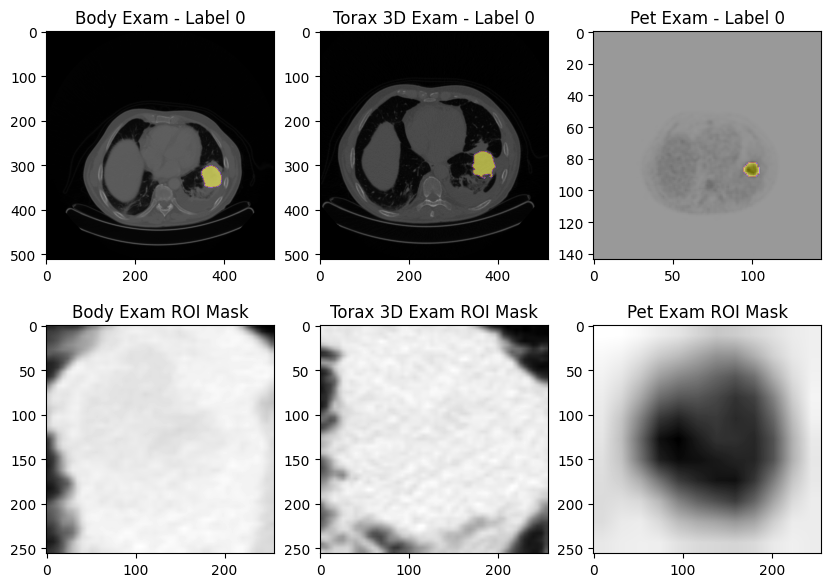

patient: sm_004
space dimensions  [1.03515625 1.03515625 3.        ] [ -265.   -195.  -1401.5]
space dimensions  [0.7890625  0.7890625  0.69995117] [-213.87368774  -72.46316528 -778.59997559]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1402.5      ]
liver roi mean:  tf.Tensor(0.74537426, shape=(), dtype=float32)


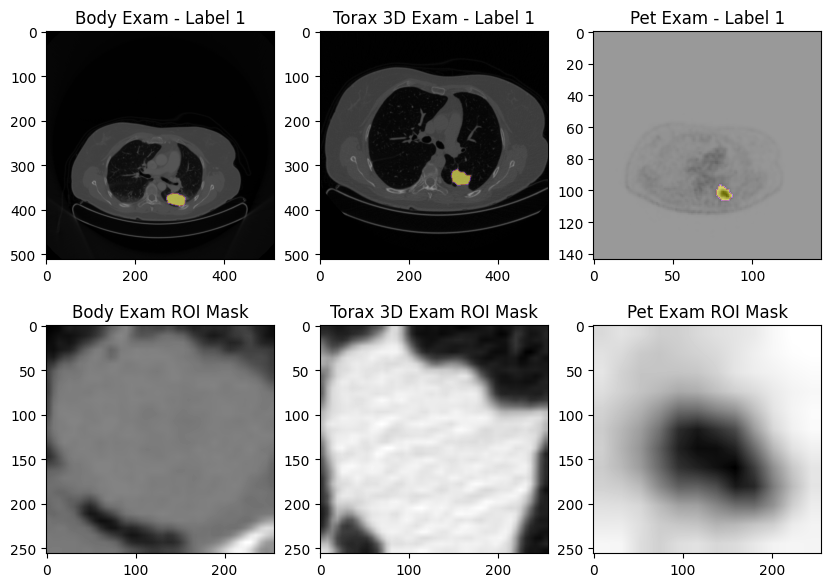

patient: sm_015
space dimensions  [1.06445312 1.06445312 3.        ] [ -272.5  -202.5 -1325.5]
space dimensions  [0.91992188 0.91992188 0.69995117] [-229.5        -128.3157959  -787.09997559]
space dimensions  [4. 4. 4.] [ -286.585938  -216.585938 -1326.5     ]
liver roi mean:  tf.Tensor(1.1451682, shape=(), dtype=float32)


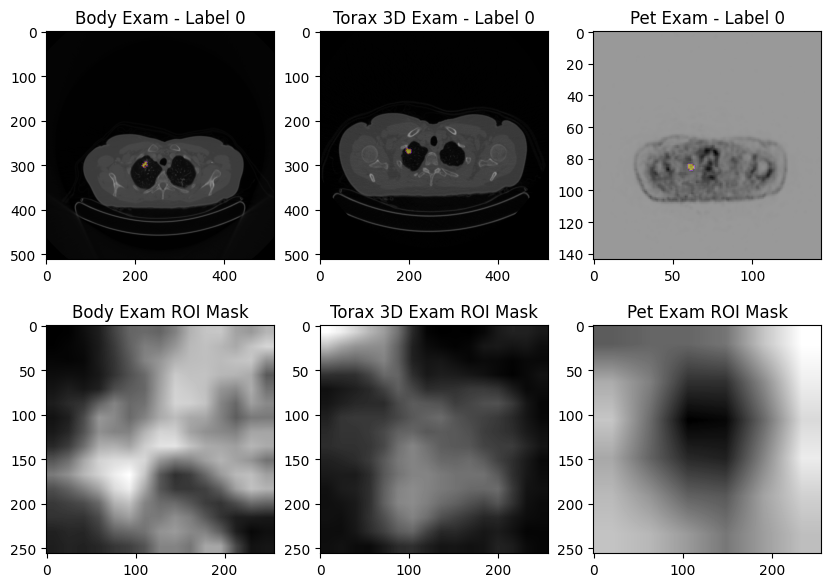

patient: sm_022
space dimensions  [1.06640625 1.06640625 3.        ] [ -273.  -203. -1410.]
space dimensions  [0.75976562 0.75976562 0.70007324] [-196.54736328  -83.55263519 -893.90002441]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1411.5      ]
liver roi mean:  tf.Tensor(0.50895905, shape=(), dtype=float32)


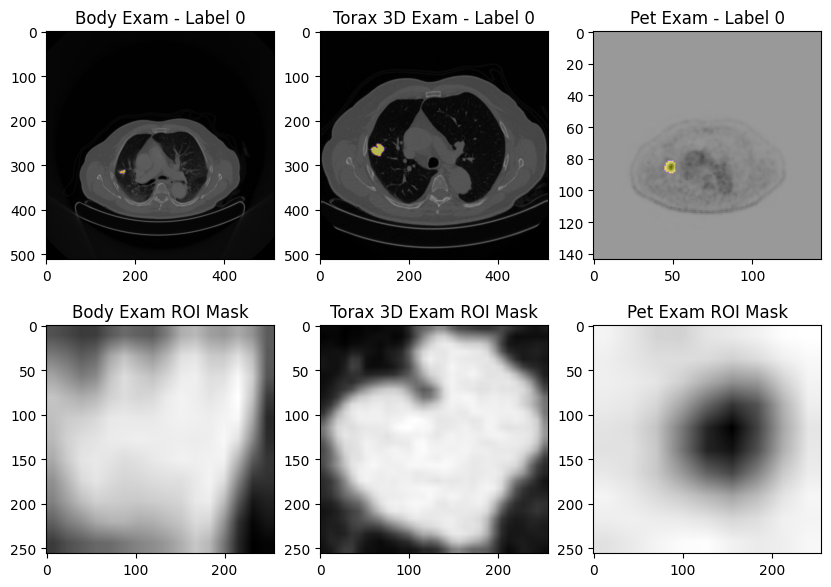

patient: sm_016
space dimensions  [0.98828125 0.98828125 3.        ] [ -253.   -183.  -1468.5]
space dimensions  [0.77734375 0.77734375 0.70007324] [-205.09474182 -108.05262756 -859.90002441]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1469.5      ]
liver roi mean:  tf.Tensor(0.870728, shape=(), dtype=float32)


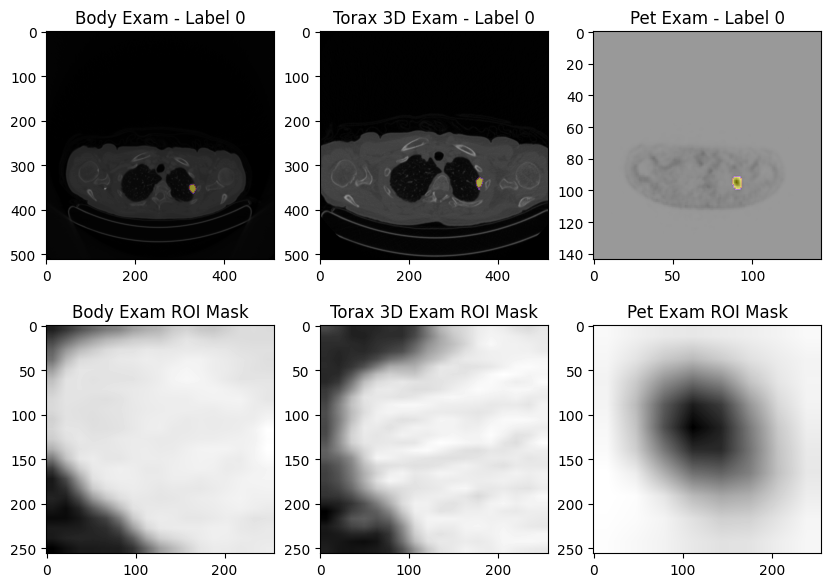

patient: sm_033
space dimensions  [0.9453125 0.9453125 3.       ] [ -242.  -172. -1200.]
space dimensions  [0.75976562 0.75976562 0.70001221] [-198.55200195 -101.12399292 -799.29998779]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1201.5      ]
liver roi mean:  tf.Tensor(0.73732674, shape=(), dtype=float32)


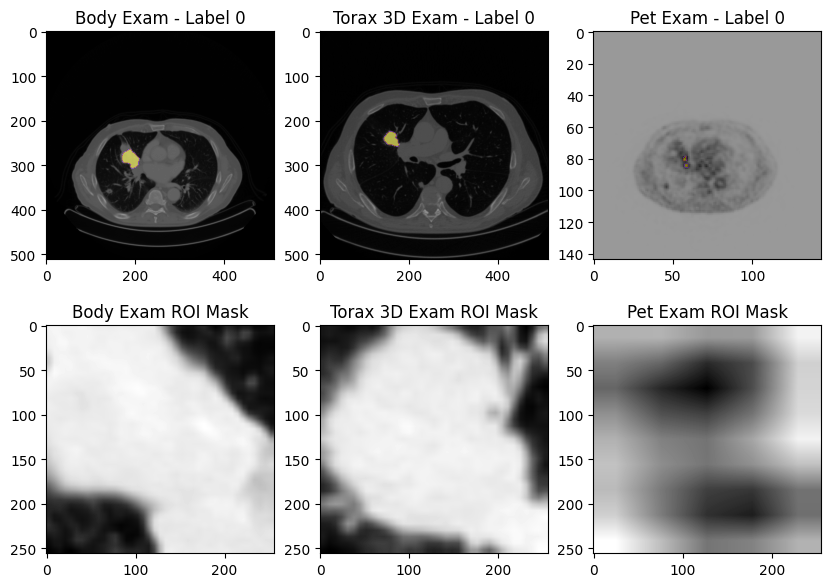

patient: sm_029
space dimensions  [1.00585938 1.00585938 3.        ] [ -257.5  -187.5 -1191. ]
space dimensions  [0.7421875  0.7421875  0.70001221] [-182.   -48.  -766.5]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1192.       ]
liver roi mean:  tf.Tensor(1.4086617, shape=(), dtype=float32)


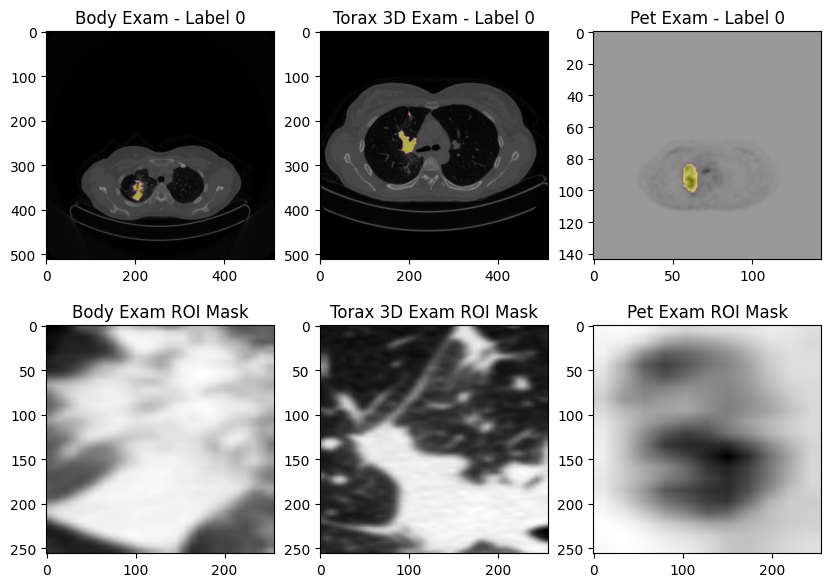

patient: sm_001
space dimensions  [1.019531 1.019531 1.25    ] [ -261.  -261. -1042.]
space dimensions  [1.019531 1.019531 1.25    ] [ -261.  -261. -1042.]
space dimensions  [3.64583325 3.64583325 3.27001953] [ -348.17709351  -348.17709351 -1032.56506348]
liver roi mean:  tf.Tensor(0.5160898, shape=(), dtype=float32)


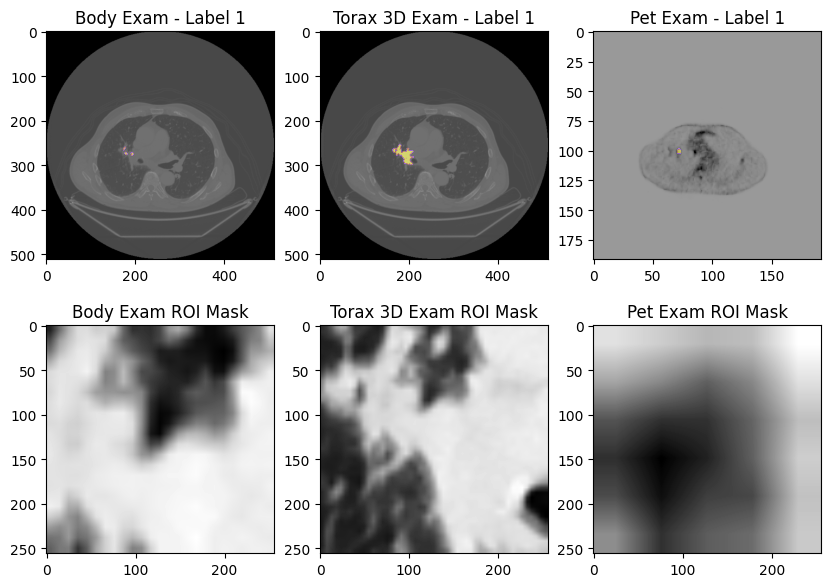

patient: sm_007
space dimensions  [0.98046875 0.98046875 3.        ] [ -251.   -181.  -1393.5]
space dimensions  [0.78710938 0.78710938 0.70007324] [-189.74211121  -95.44210052 -838.40002441]
space dimensions  [4. 4. 4.] [ -286.5859375  -216.5859375 -1394.5      ]
liver roi mean:  tf.Tensor(0.8625658, shape=(), dtype=float32)


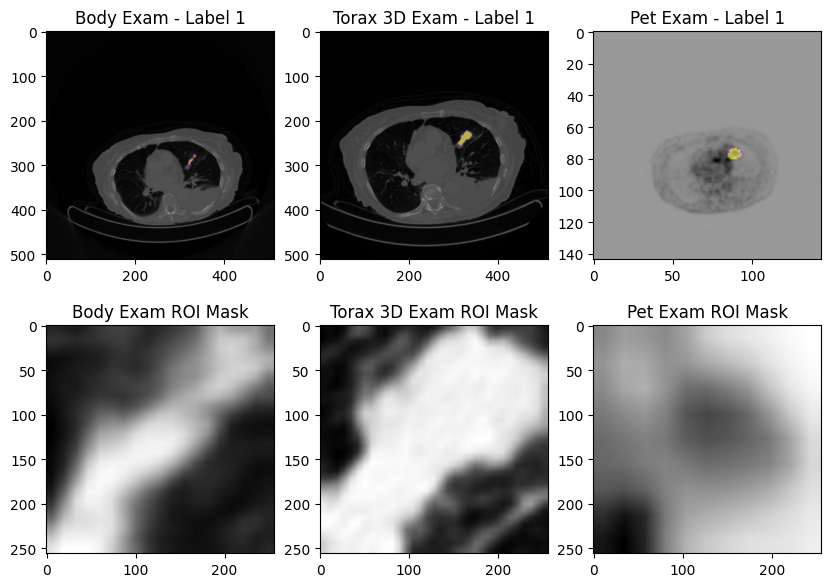

patient: sm_011
space dimensions  [1.09375 1.09375 3.     ] [ -280.  -210. -1437.]
space dimensions  [0.77539062 0.77539062 0.69995117] [-204.5         -88.79999542 -943.89996338]
space dimensions  [4. 4. 4.] [ -286.5859375   -216.5859375  -1438.30004883]
liver roi mean:  tf.Tensor(1.5709401, shape=(), dtype=float32)


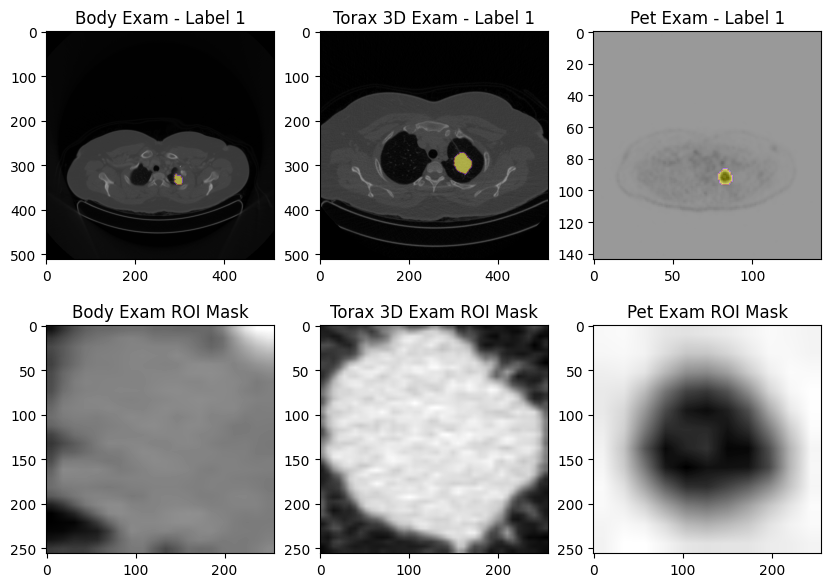

In [5]:
# se cargan los conjuntos de datos de santa maria
# incluir spacing en santamaria_info
santamaria_body_dataset, santamaria_body_info = tfds.load('santa_maria_dataset/body', with_info=True, data_dir='/media/roberto/TOSHIBA EXT/tensorflow_ds/')
santamaria_torax_dataset, santamaria_torax_info = tfds.load('santa_maria_dataset/torax3d', with_info=True, data_dir='/media/roberto/TOSHIBA EXT/tensorflow_ds/')
santamaria_pet_dataset, santamaria_pet_info = tfds.load('santa_maria_dataset/pet', with_info=True, data_dir='/media/roberto/TOSHIBA EXT/tensorflow_ds/')

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1

visualize_n_samples(n_patients, n_samples, 
                    santamaria_body_dataset, santamaria_body_info, santamaria_torax_dataset, 
                     santamaria_torax_info, santamaria_pet_dataset, santamaria_pet_info)

patient: R01-100
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -842.52]
space dimensions  [0.683594 0.683594 1.25    ] [-175.  -151.5 -538. ]
space dimensions  [3.64583325 3.64583325 3.27000009] [-348.17709351 -348.17709351 -842.52001953]
liver roi mean:  tf.Tensor(1.0368394, shape=(), dtype=float32)


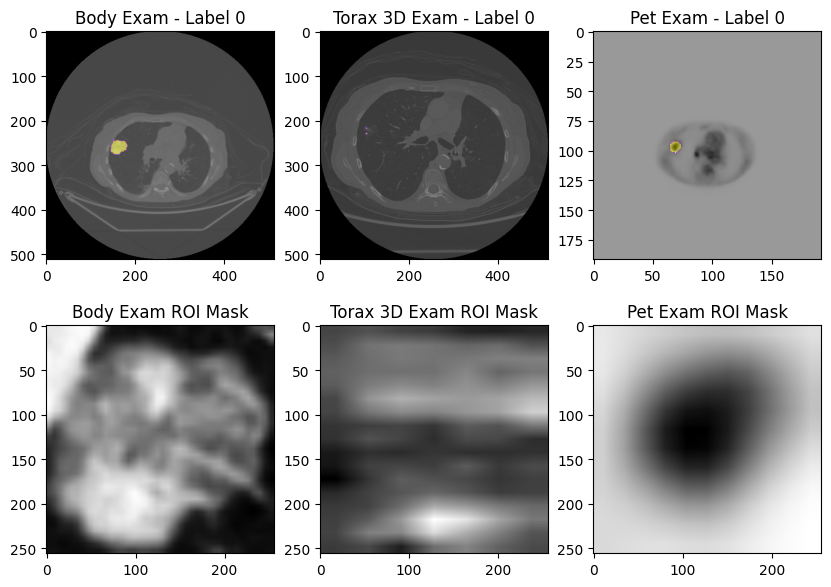

patient: R01-091
space dimensions  [0.9765625 0.9765625 4.       ] [-249.51171875 -398.51171875 -897.        ]
space dimensions  [0.69921875 0.69921875 1.        ] [-176.65039062 -324.65039062 -359.        ]
space dimensions  [4.07283 4.07283 3.     ] [-341.830471   -492.52183997 -896.        ]
liver roi mean:  tf.Tensor(0.98948425, shape=(), dtype=float32)


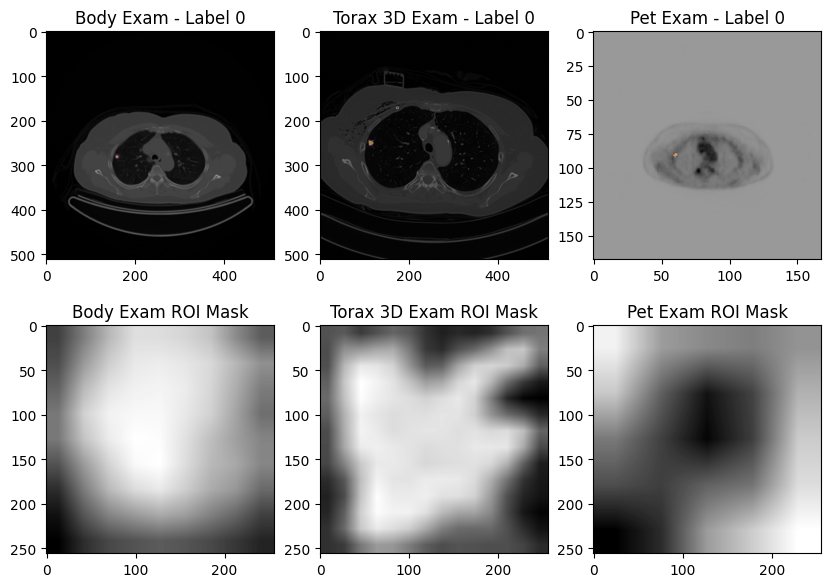

patient: R01-004
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -874.62]
space dimensions  [0.828125 0.828125 1.25    ] [-207.9 -212.  -410.5]
space dimensions  [3.90625    3.90625    3.26999974] [-248.046875  -248.046875  -874.5997925]
liver roi mean:  tf.Tensor(-3.1529822, shape=(), dtype=float32)


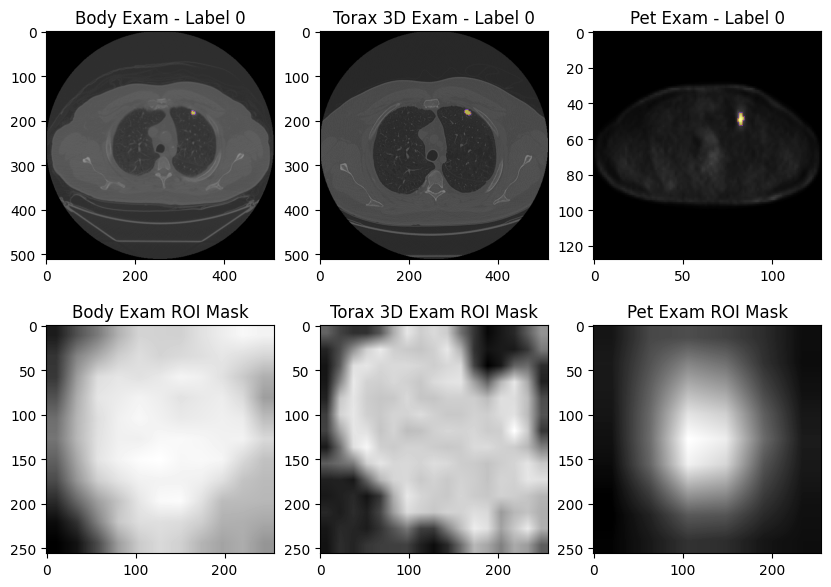

patient: R01-033
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -850.62]
space dimensions  [0.839844 0.839844 1.25    ] [-199.5  -215.   -337.75]
space dimensions  [3.90625    3.90625    3.26999974] [-248.046875  -248.046875  -850.5997925]
liver roi mean:  tf.Tensor(-2.746899, shape=(), dtype=float32)


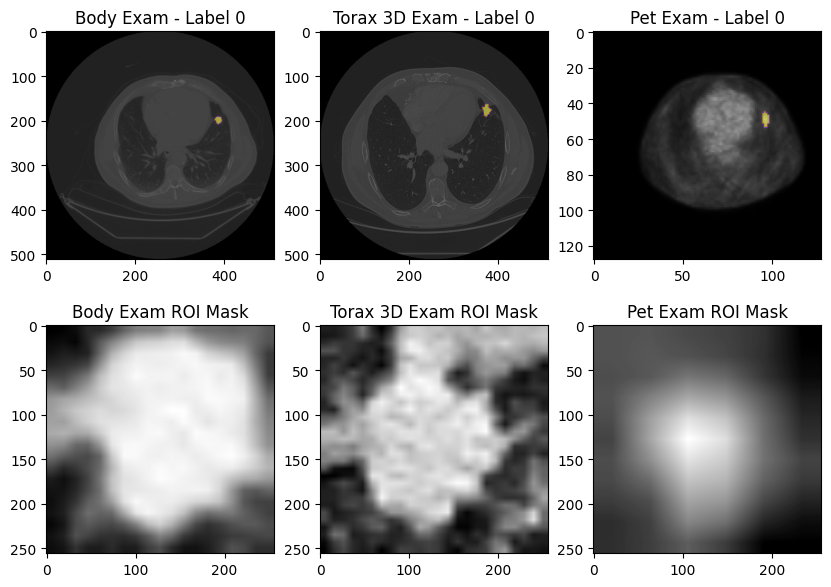

patient: AMC-049
space dimensions  [0.976562 0.976562 4.25    ] [ -250.  -250. -1012.]
space dimensions  [0.89257812 0.89257812 1.        ] [-207.05371094 -357.17371094 -428.5       ]
space dimensions  [4.296875 4.296875 4.25    ] [ -275.  -275. -1012.]
liver roi mean:  tf.Tensor(2.2677102, shape=(), dtype=float32)


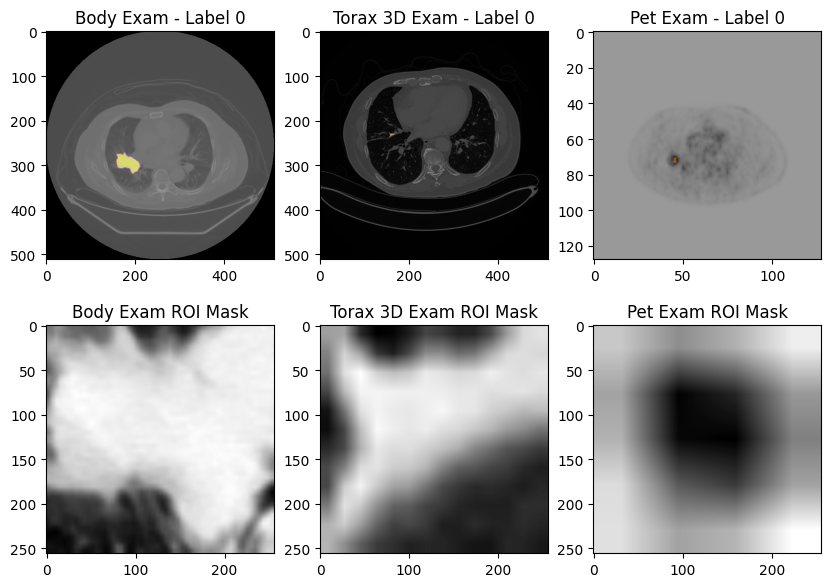

patient: R01-053
space dimensions  [0.976562 0.976562 3.27    ] [ -250.   -250.  -1798.5]
space dimensions  [0.621094 0.621094 2.5     ] [-157.710541 -126.010162 -281.75    ]
space dimensions  [3.64583325 3.64583325 3.27      ] [ -348.17709351  -348.17709351 -1798.5       ]
liver roi mean:  tf.Tensor(0.41591617, shape=(), dtype=float32)


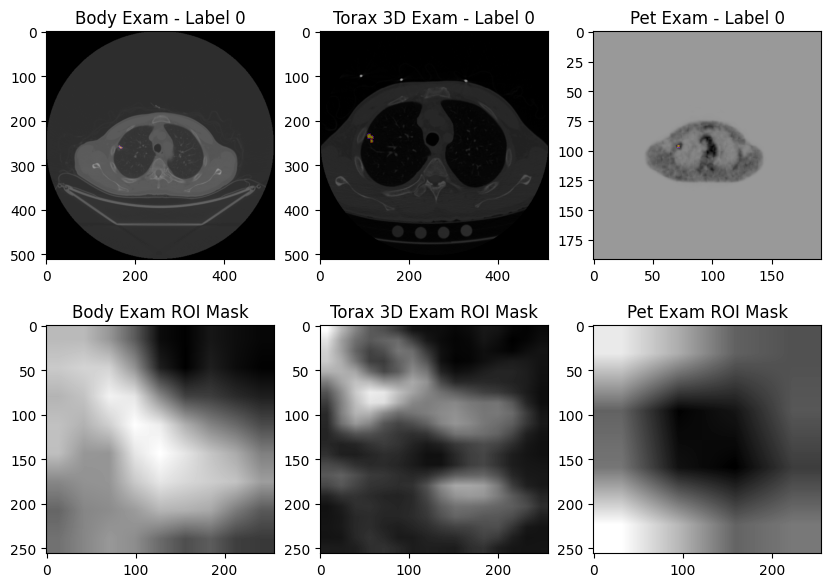

patient: R01-025
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -820.62]
space dimensions  [0.759766 0.759766 0.625   ] [-180.  -194.5 -369. ]
space dimensions  [3.90625    3.90625    3.26999974] [-248.046875  -248.046875  -820.5997925]
liver roi mean:  tf.Tensor(-1.885193, shape=(), dtype=float32)


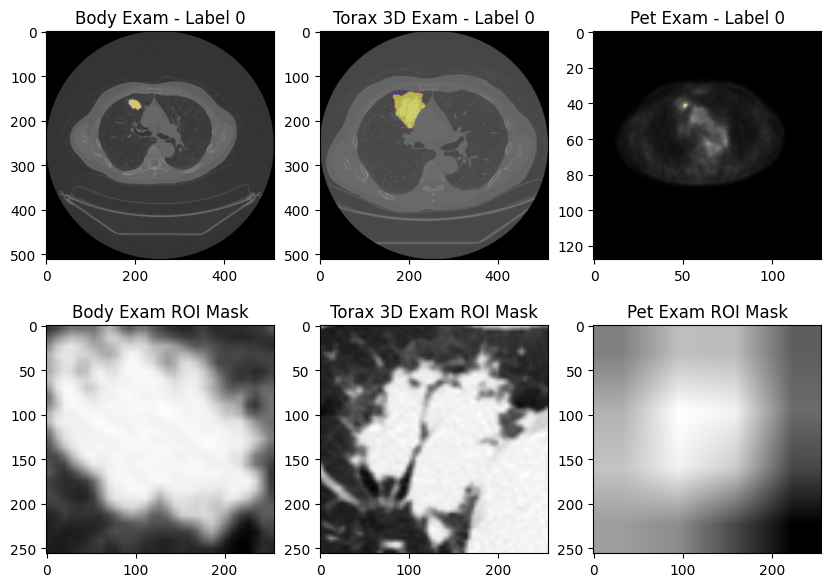

patient: R01-012
space dimensions  [0.976562 0.976562 4.25    ] [-250. -250. -900.]
space dimensions  [0.69921875 0.69921875 1.        ] [-189.65039062 -310.65039062 -385.5       ]
space dimensions  [4.296875 4.296875 4.25    ] [-275. -275. -900.]
liver roi mean:  tf.Tensor(1.9385539, shape=(), dtype=float32)


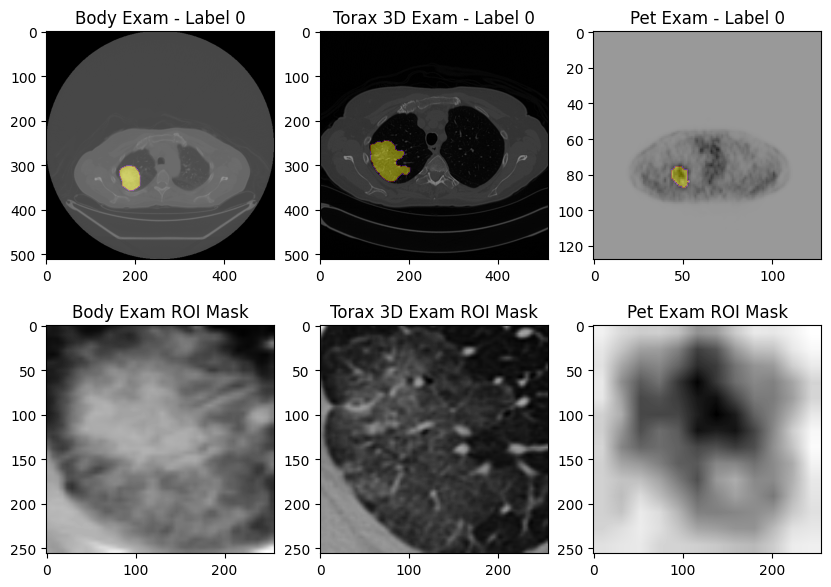

patient: R01-007
space dimensions  [0.976562 0.976562 3.27    ] [-250.   -250.   -843.62]
space dimensions  [0.769531 0.769531 1.25    ] [-197.  -197.  -358.5]
space dimensions  [3.90625    3.90625    3.26999974] [-248.046875  -248.046875  -843.5997925]
liver roi mean:  tf.Tensor(-1.6374302, shape=(), dtype=float32)


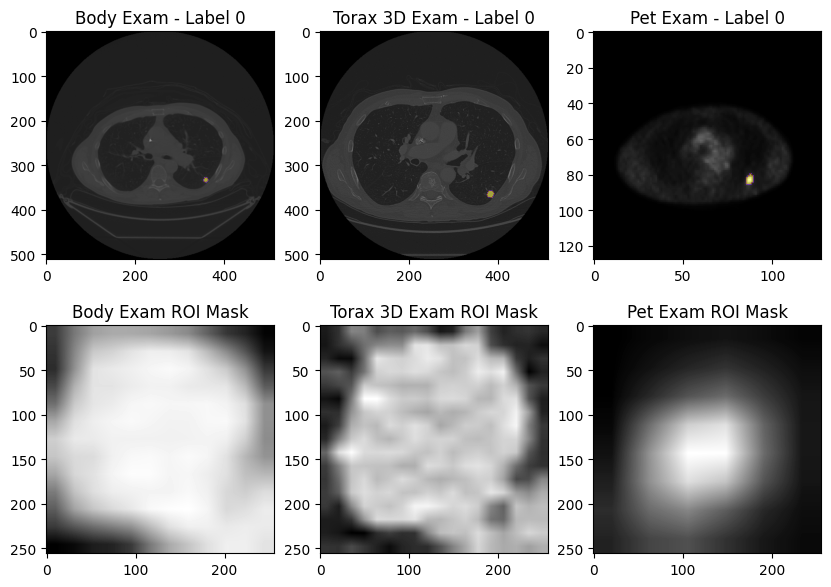

patient: AMC-022
space dimensions  [0.87890625 0.87890625 5.        ] [-225.  -155.  -830.5]
space dimensions  [0.68359375 0.68359375 0.80000006] [-191.        -11.       -257.800018]
space dimensions  [0. 0. 0.] [ 286. -286.  848.]
liver roi mean:  tf.Tensor(0.058390208, shape=(), dtype=float32)


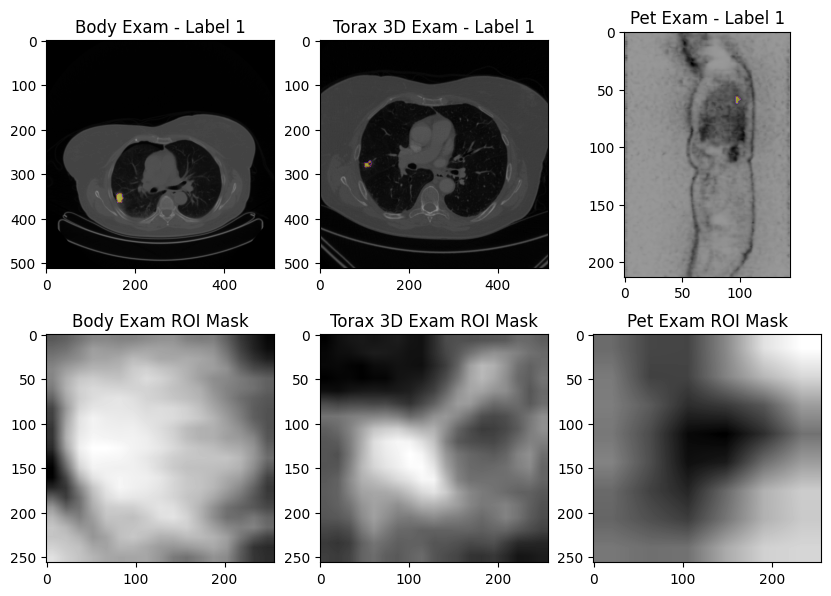

In [6]:
# se cargan los conjuntos de datos de santa maria
stanford_body_dataset, stanford_body_info = tfds.load('stanford_dataset/ct', with_info=True, data_dir='/media/roberto/TOSHIBA EXT/tensorflow_ds/')
stanford_torax_dataset, stanford_torax_info = tfds.load('stanford_dataset/chest_ct', with_info=True, data_dir='/media/roberto/TOSHIBA EXT/tensorflow_ds/')
stanford_pet_dataset, stanford_pet_info = tfds.load('stanford_dataset/pet', with_info=True, data_dir='/media/roberto/TOSHIBA EXT/tensorflow_ds/')

# cantidad de pacientes a mostrar, cantidad de ejemplos y función de extraccion de ROI
n_patients = 10
n_samples = 1

visualize_n_samples(n_patients, n_samples, 
                    stanford_body_dataset, stanford_body_info, stanford_torax_dataset, 
                    stanford_torax_info, stanford_pet_dataset, stanford_pet_info)
